# Laboratorul 9

Rezolvați exercițiile de mai jos în celulele care v-au fost puse la dispoziție. La final, rulați tot notebook-ul și asigurați-vă că nu aveți erori. Salvați fișierul și încărcați-l în assignment-ul de Teams corespunzător grupei voastre.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, filtfilt, freqz
import pandas as pd

## Exercițiul 1

 Scrieți câte o funcție prin care să construiți o **fereastră    dreptunghiulară**, respectiv o **fereastră de tip Hanning**. Funcțiile primesc ca parametru **lungimea ferestrei**.

 Generați și afișați o sinusoidă cu frecvență $f = 100 \, \text{Hz}$, amplitudine unitară și fază nulă, apoi treceți-o prin cele două tipuri de ferestre (pentru lungimea $N_w = 200$) și afișați grafic rezultatul.

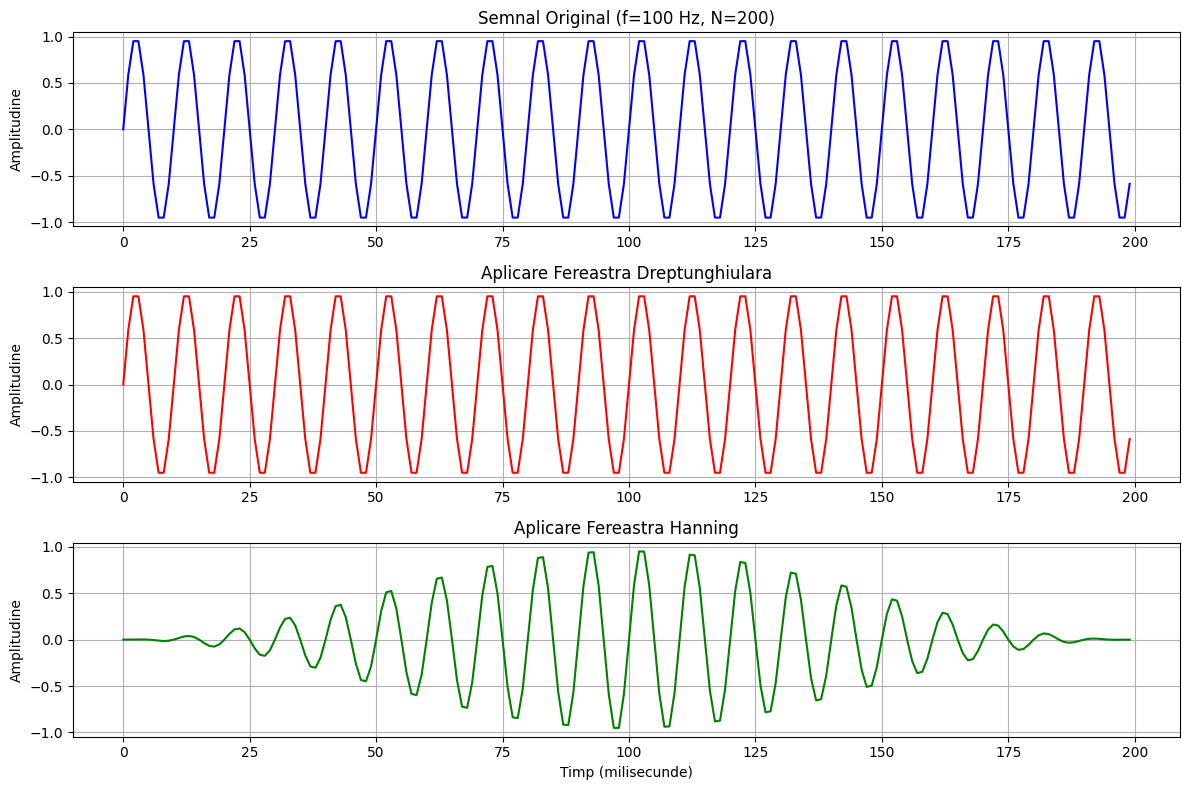

In [6]:
freq = 100
A = 1
phase = 0
length = 200
sampling_rate = 1000

def rectangular_window(length):
    return np.ones(length)

def hanning_window(length):
    return np.hanning(length)

def generate_sinusoid(frequency, amplitude, phase, sampling_rate, N):
    t = np.arange(N) / sampling_rate
    sinusoid = amplitude * np.sin(2 * np.pi * frequency * t + phase)
    return t, sinusoid

t, sinusoid = generate_sinusoid(freq, A, phase, sampling_rate, length)

rect_window = rectangular_window(length)
hann_window = hanning_window(length)

sinusoid_windowed_rect = sinusoid * rect_window
sinusoid_windowed_hann = sinusoid * hann_window

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t * 1000, sinusoid, 'b-')
plt.title(f'Semnal Original (f={freq} Hz, N={length})')
plt.ylabel('Amplitudine')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t * 1000, sinusoid_windowed_rect, 'r-')
plt.title('Aplicare Fereastra Dreptunghiulara')
plt.ylabel('Amplitudine')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t * 1000, sinusoid_windowed_hann, 'g-')
plt.title('Aplicare Fereastra Hanning')
plt.xlabel('Timp (milisecunde)')
plt.ylabel('Amplitudine')
plt.grid(True)

plt.tight_layout()
plt.show()





## Exercițiul 2

Fișierul `traffic-one-week.csv` conține date de trafic colectate pe o perioadă de o săptămână. Perioada de eșantionare este de o oră, iar valorile măsurate reprezintă numărul de vehicule care trec printr-o intersecție.

### Subpunctul a)

Încărcați datele în memorie și selectați din semnalul dat o porțiune corespunzătoare pentru **3 zile**, `x`, pe care veți lucra în continuare.

     vehicles
0          10
1          18
2          18
3          32
4          38
..        ...
163        10
164        10
165         4
166         4
167         4

[168 rows x 1 columns]


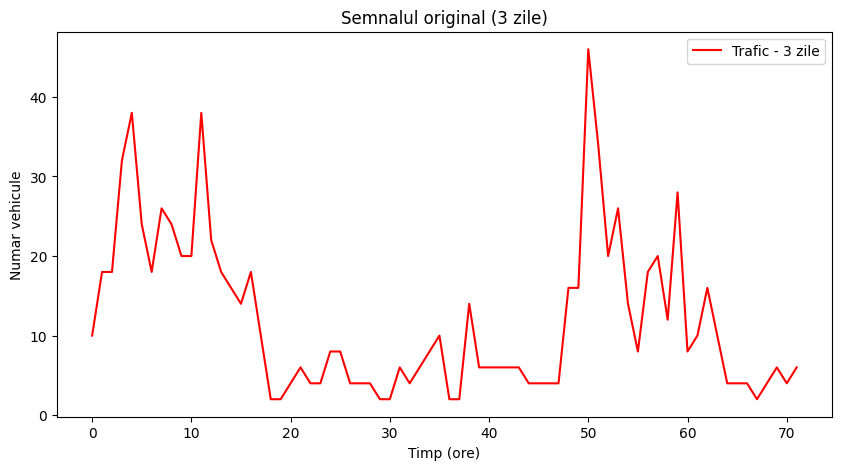

In [14]:
file_path = "assets/traffic-one-week.csv"
traffic_data = pd.read_csv(file_path, header=None, names=["vehicles"])


print(traffic_data)

data_3 = traffic_data.iloc[:(24*3)]['vehicles'].values
Nw = len(data_3)

plt.figure(figsize=(10, 5))
plt.plot(data_3, label="Trafic - 3 zile",color='red')
plt.title("Semnalul original (3 zile)")
plt.xlabel("Timp (ore)")
plt.ylabel("Numar vehicule")
plt.legend()
plt.show()



### Subpunctul b)

Utilizați funcția `np.convolve(x, np.ones(w), 'valid') / w` pentru a realiza un filtru de tip medie alunecătoare și neteziți semnalul obținut anterior. Setați dimensiuni diferite ale ferestrei (variabila `w` în codul de mai sus), spre exemplu $5$, $9$, $13$, $17$. Afișați grafic semnalele obținute.

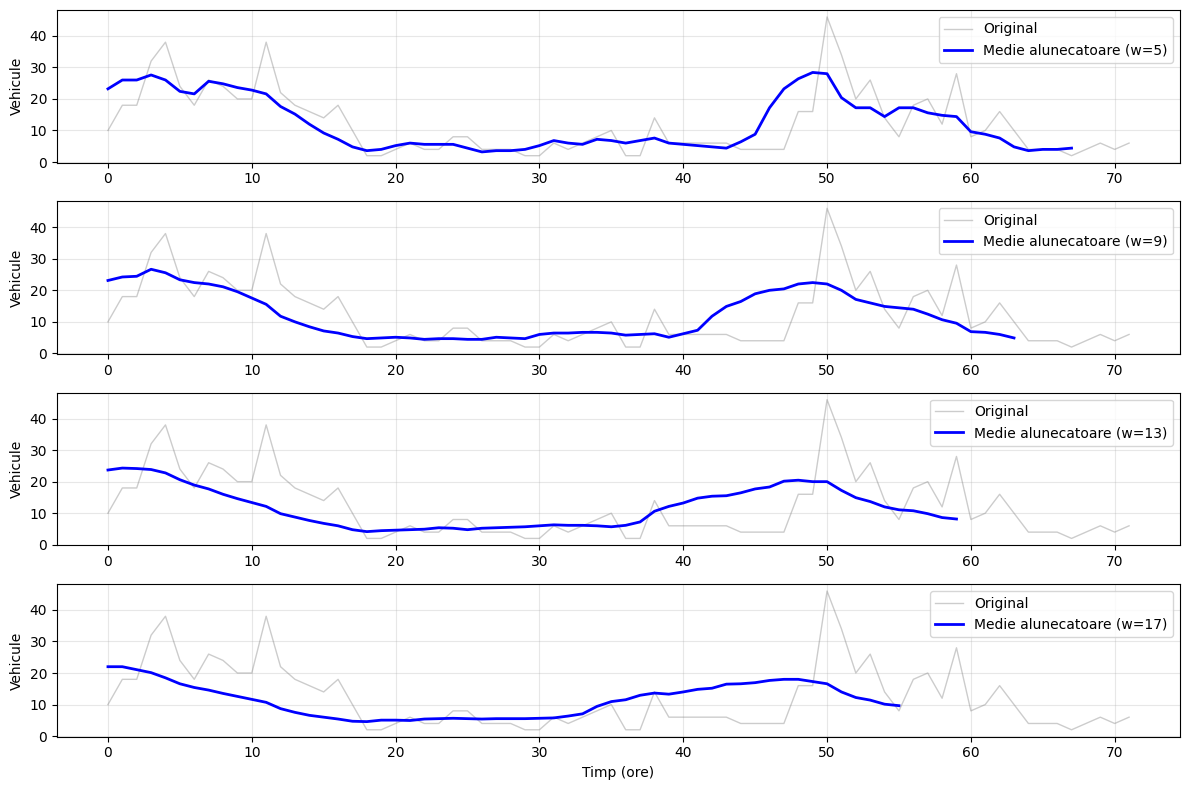

In [22]:
def moving_average_filter(signal, window_size):
    return np.convolve(signal, np.ones(window_size), 'valid') / window_size

window_sizes = [5, 9, 13, 17]
filtered_signals = [moving_average_filter(data_3, w) for w in window_sizes]

plt.figure(figsize=(12, 8))
for i, (w, filtered_signal) in enumerate(zip(window_sizes, filtered_signals), start=1):
    plt.subplot(len(window_sizes), 1, i)
    plt.plot(data_3, 'gray', alpha=0.4, linewidth=1, label='Original')
    plt.plot(filtered_signal, 'b-', linewidth=2, label=f'Medie alunecatoare (w={w})')
    plt.ylabel('Vehicule')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if i == len(window_sizes):
        plt.xlabel('Timp (ore)')
plt.tight_layout()
plt.show()

### Subpunctul c)

Dorinți să filtrați **zgomotul** (frecvențe înalte) din semnalul cu date de trafic. Alegeți o **frecvență de tăiere** pentru un filtru trece-jos pe care îl veți crea în subpunctul următor. Argumentați alegerea făcută.

**Indicație:** transformata Fourier a semnalului, calculată în laboratorul anterior, ar putea să vă ajute cu luarea acestei decizii.

Pe lângă valoarea frecvenței în Herzi, determinați și valoarea ei normalizată între 0 și 1, unde 1 reprezintă frecvența Nyquist pentru semnalul de trafic.

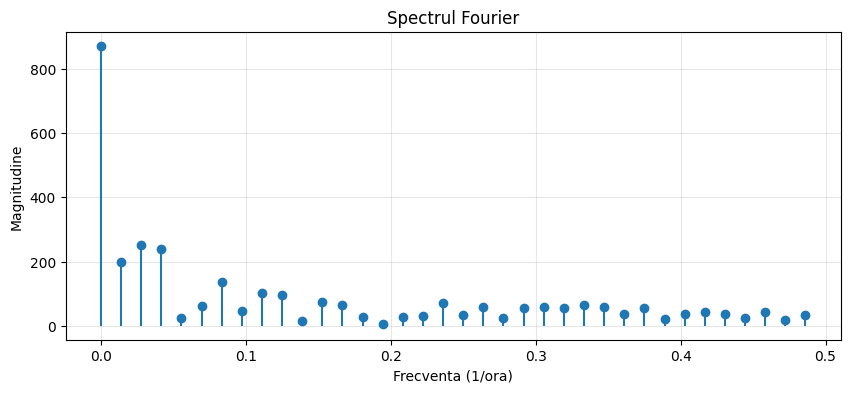

Cutoff: 0.15, Normalized: 0.3


In [17]:
fft_vals = np.fft.fft(data_3)
freq_axis = np.fft.fftfreq(len(data_3), d=1)
mag = np.abs(fft_vals)

plt.figure(figsize=(10, 4))
plt.stem(freq_axis[:len(freq_axis)//2], mag[:len(freq_axis)//2], basefmt=' ')
plt.xlabel('Frecventa (1/ora)')
plt.ylabel('Magnitudine')
plt.title('Spectrul Fourier')
plt.grid(True, alpha=0.3)
plt.show()

cutoff = 0.15
nyquist = 0.5
norm_cutoff = cutoff / nyquist
print(f'Cutoff: {cutoff}, Normalized: {norm_cutoff}')


### Subpunctul d)

Utilizați funcția `scipy.signal.butter`, respectiv funcția `scipy.signal.cheby1`, pentru a **proiecta** filtrele Butterworth și Chebyshev de ordin 5, cu frecvența de tăiere $W_n$ (valoare normalizată), stabilită la subpunctul anterior.
        
Pentru început, setați atenuarea ondulațiilor la `rp = 5` (dB), urmând ca apoi să încercați și alte valori.

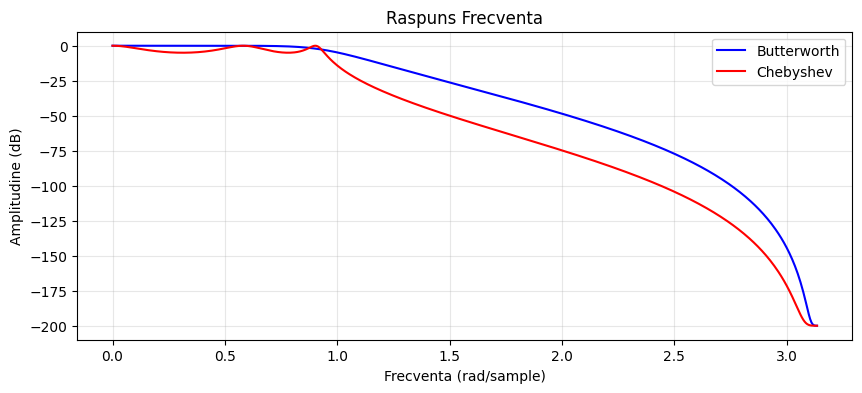

In [24]:
order = 5
rp = 5

b_but, a_but = butter(order, norm_cutoff, btype='low')
b_cheb, a_cheb = cheby1(order, rp, norm_cutoff, btype='low')

w_but, h_but = freqz(b_but, a_but)
w_cheb, h_cheb = freqz(b_cheb, a_cheb)

plt.figure(figsize=(10, 4))
plt.plot(w_but, 20 * np.log10(np.abs(h_but) + 1e-10), 'b-', label='Butterworth')
plt.plot(w_cheb, 20 * np.log10(np.abs(h_cheb) + 1e-10), 'r-', label='Chebyshev')
plt.xlabel('Frecventa (rad/sample)')
plt.ylabel('Amplitudine (dB)')
plt.title('Raspuns Frecventa')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Subpunctul e)

**Filtrați** datele de trafic cu cele 2 filtre și afișați semnalele filtrate împreună cu datele brute. Ce filtru alegeți dintre cele două și de ce?

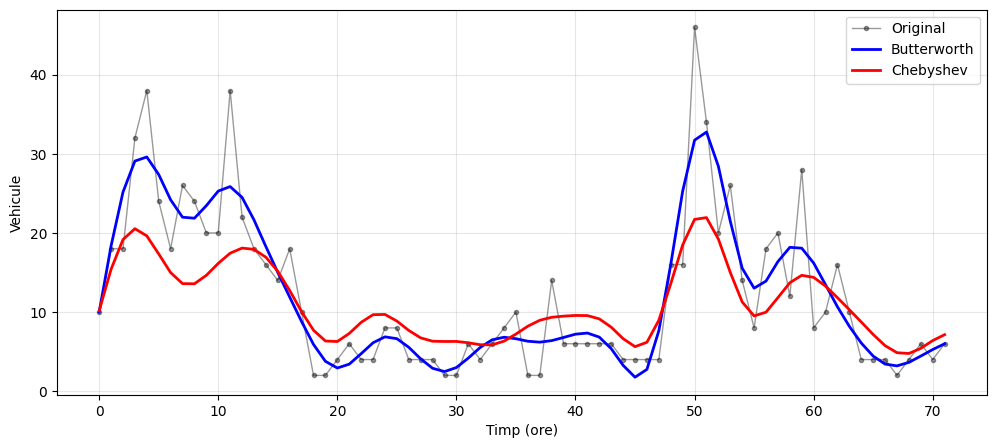

In [25]:
filt_but = filtfilt(b_but, a_but, data_3)
filt_cheb = filtfilt(b_cheb, a_cheb, data_3)

plt.figure(figsize=(12, 5))
plt.plot(data_3, 'ko-', alpha=0.4, linewidth=1, markersize=3, label='Original')
plt.plot(filt_but, 'b-', linewidth=2, label='Butterworth')
plt.plot(filt_cheb, 'r-', linewidth=2, label='Chebyshev')
plt.xlabel('Timp (ore)')
plt.ylabel('Vehicule')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Subpunctul f)

Reproiectați filtrele alegând atât un ordin mai mic, cât și unul mai mare. De asemenea, reproiectați filtrul Chebyshev cu alte valori ale `rp` și observați efectul.

Stabiliți **valorile optime** ale parametrilor pentru a vă atinge scopul (cel de a filtra zgomotul din semnal).

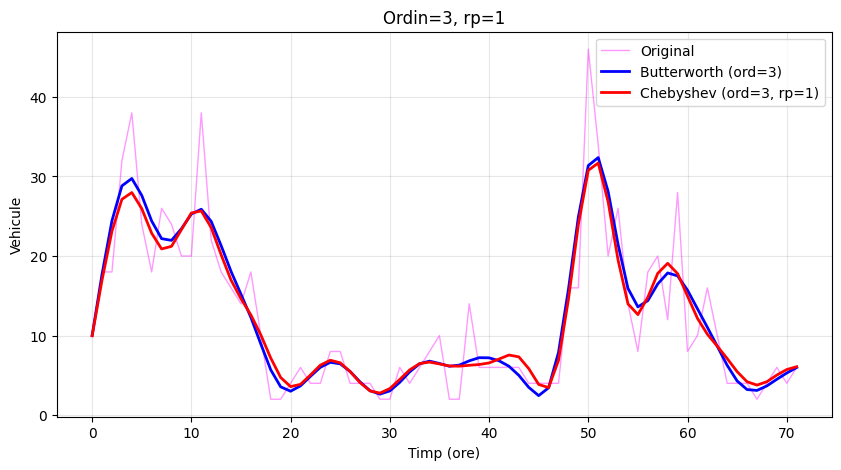

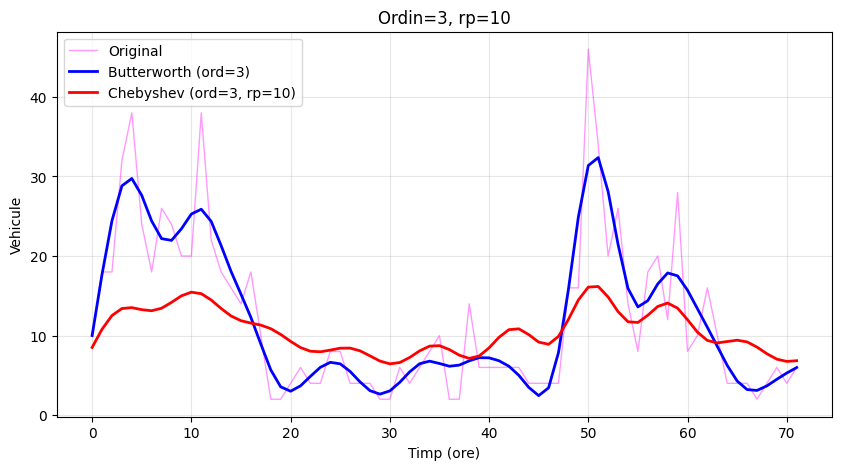

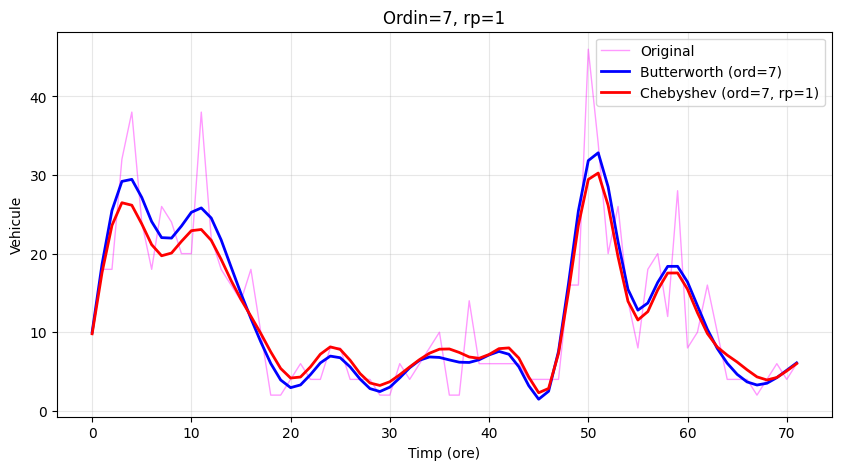

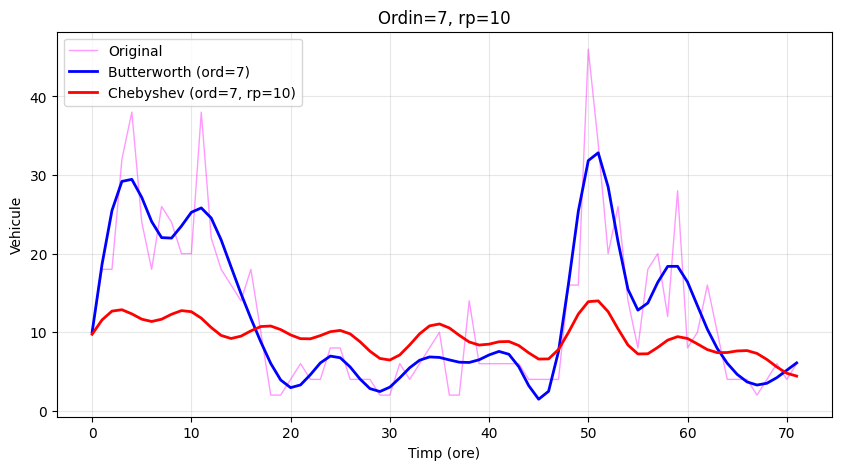

In [21]:
orders = [3, 7]
rp_vals = [1, 10]

for o in orders:
    b_but, a_but = butter(o, norm_cutoff, btype='low')
    filt_but = filtfilt(b_but, a_but, data_3)
    
    for rp in rp_vals:
        b_cheb, a_cheb = cheby1(o, rp, norm_cutoff, btype='low')
        filt_cheb = filtfilt(b_cheb, a_cheb, data_3)
        
        plt.figure(figsize=(10, 5))
        plt.plot(data_3, 'magenta', alpha=0.4, linewidth=1, label='Original')
        plt.plot(filt_but, 'b-', linewidth=2, label=f'Butterworth (ord={o})')
        plt.plot(filt_cheb, 'r-', linewidth=2, label=f'Chebyshev (ord={o}, rp={rp})')
        plt.xlabel('Timp (ore)')
        plt.ylabel('Vehicule')
        plt.title(f'Ordin={o}, rp={rp}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()